# 6. Transfer Learning in TensorFlow - Fine Tuning

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf

tf.__version__

'2.9.1'

In [2]:
# Check if we're using a GPU
!nvidia-smi

Tue Jul  5 20:11:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8     6W /  N/A |     81MiB /  6144MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import helper functions we're going to use in this notebook
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Lets get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem

In [4]:
# Get 10% of train data of 10 classes of Food101
!curl "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip" --output "Data/Classification/10_food_classes_10_percent.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  160M    0 19396    0     0  16774      0  2:47:28  0:00:01  2:47:27 16793
  2  160M    2 4096k    0     0  2588k      0  0:01:03  0:00:01  0:01:02 2589k
  9  160M    9 14.6M    0     0  5869k      0  0:00:28  0:00:02  0:00:26 5870k
 15  160M   15 25.6M    0     0  7379k      0  0:00:22  0:00:03  0:00:19 7380k
 22  160M   22 36.7M    0     0  8238k      0  0:00:19  0:00:04  0:00:15 8238k
 28  160M   28 46.2M    0     0  8513k      0  0:00:19  0:00:05  0:00:14 10.4M
 34  160M   34 56.2M    0     0  8777k      0  0:00:18  0:00:06  0:00:12 10.4M
 40  160M   40 65.3M    0     0  8848k      0  0:00:18  0:00:07  0:00:11 10.1M
 43  160M   43 70.3M    0     0  8414k      0  0:00:19  0:00:08  0:00:11 9151k
 49  160M   49 79.1M    0     0  8479k      0  0:00

In [5]:
zip_file = zipfile.ZipFile("Data/Classification/10_food_classes_10_percent.zip")
zip_file.extractall("Data/Classification")
zip_file.close()

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("Data/Classification/10_food_classes_10_percent")

There are 2 directories and 0 images in 'Data/Classification/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'Data/Classification/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'Data/Classif

In [7]:
# Create training and test directory paths
train_dir = "Data/Classification/10_food_classes_10_percent/train"
test_dir = "Data/Classification/10_food_classes_10_percent/test"

This time instead of using `ImageDataGenerator` we'll use `tf.keras.preprocessing.image_dataset_from_directory`. This is because it creates a `tf.data.Dataset` object which is much faster to process.

In [8]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data.take(1):
    print(images.shape)
    print(labels.shape)

(32, 224, 224, 3)
(32, 10)


## Modelling experiments we're running
|Experiment|Data|Preprocessing|Model|
|----------|----|-------------|-----|
|Model 0 (baseline)|10 classes of Food101 data (random 10% training data only)|None|Feature Extractor: EfficientNetB0 (pretrained on ImageNet, all layers frozen) with no top|
|Model 1|10 classes of Food101 data (random 1% training data only)|Random Flip, Rotation, Zoom, Height, Width data augmentation|Same as Model 0|
|Model 2|Same as Model 0|Same as Model 1|Same as model 0|
|Model 3|Same as Model 0|Same as Model 1|Fine-tuning: Model 2 (EfficientNetB0 pre-trained on ImageNet) with top layer trained on custom data, top 10 layers unfrozen|
|Model 4|10 classes of Food101 data (100% training data)|Same as Model 1|Same as Model 3|

## Keras Sequential vs Functional API

Sequential API
sequential_model = tf.keras.Sequential(<br>
    [<br>
        tf.keras.layers.Flatten(),<br>
        tf.keras.layers.Dense(64, activation = "relu")<br>
        tf.keras.layers.Dense(64, activation = "relu")<br>
        tf.keras.layers.Dense(10, activation = "softmax")<br>
    ], name = "sequential_model"<br>
)<br>

Functional API<br>
inputs = tf.keras.layers.Input(shape = (28,28))<br>
x = tf.keras.layers.Flatten()(inputs)<br>
x = tf.keras.layers.Dense(64, activation = "relu")(x)<br>
x = tf.keras.layers.Dense(64, activation = "relu")(x)<br>
outputs = tf.keras.layers.Dense(10, activation = "softmax")(x)<br>
functional_model = tf.keras.Model(inputs, outputs, name = "functional_model")<br>


Similarities: compiling, fitting, evaluating
Differences: model construction (the Functional API is more flexible and able to produce more sophisticated models)

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models.

In [12]:
# 1. Create the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top = False,
)

# 2. Freeze the base model (so that the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create the inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using Resnet50v2 you will need to normalize inputs; dont need to for efficient-net
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) 

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through the base model: {x.shape}")

# 6. Average Pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after passing inputs through the global average pooling layer model: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs, name = "model_0")
model_0.summary()

Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after passing inputs through the global average pooling layer model: (None, 1280)
Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
__________________

In [13]:
# Compile the model
model_0.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_0 = model_0.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback("TensorBoard/Classification", "efficientnetb0_feature_extractor")]
)

Saving TensorBoard log files to: TensorBoard/Classification/efficientnetb0_feature_extractor/20220705-201243
Epoch 1/5
24/24 [==============================] - 96s 3s/step - loss: 1.8573 - accuracy: 0.4187 - val_loss: 1.2819 - val_accuracy: 0.7440
Epoch 2/5
24/24 [==============================] - 56s 2s/step - loss: 1.0993 - accuracy: 0.7653 - val_loss: 0.8610 - val_accuracy: 0.8312
Epoch 3/5
24/24 [==============================] - 56s 2s/step - loss: 0.8053 - accuracy: 0.8280 - val_loss: 0.6921 - val_accuracy: 0.8512
Epoch 4/5
24/24 [==============================] - 56s 2s/step - loss: 0.6572 - accuracy: 0.8667 - val_loss: 0.6047 - val_accuracy: 0.8628
Epoch 5/5
24/24 [==============================] - 55s 2s/step - loss: 0.5514 - accuracy: 0.8827 - val_loss: 0.5496 - val_accuracy: 0.8652


In [14]:
model_0.evaluate(test_data)

79/79 [==============================] - 37s 468ms/step - loss: 0.5496 - accuracy: 0.8652


[0.5496498346328735, 0.8651999831199646]

In [15]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

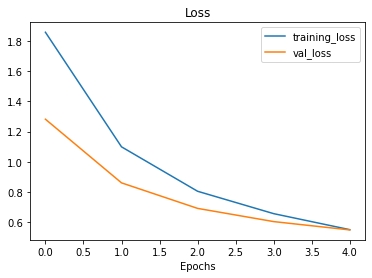

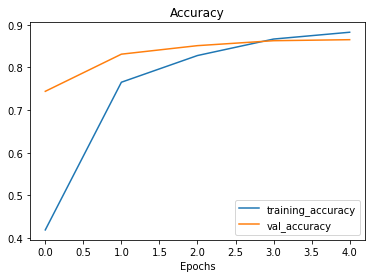

In [17]:
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Lets demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7,7, 1280)

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Lets use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [20]:
# Define the input shape
input_shape = (1,4,4,3)
tf.random.set_seed(42)

input_vector = tf.random.normal(shape = input_shape)
output = tf.keras.layers.GlobalAveragePooling2D()(input_vector)
input_vector.shape, output.shape

(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))

In [21]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_vector, axis = [1, 2]), output

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>)

## Concept of a Feature Vector

* A feature vector is a learned representation of the input data (a compressed form of the input data based on how the model sees it)

Input Data -> EfficientNetB0 (frozen;pretrained on ImageNet) -> Pooling -> Dense -> Output vector

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data.... how about we set up a bunch of experiments to find out:
1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning tranfer learning on 100% of the training data with data augmentation.

> Note: throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across evaluation metrics.

In [22]:
# Download and unzip data
if os.path.exists("Data/Classification/10_food_classes_1_percent.zip") == False:
    !curl "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip" --output "Data/Classification/10_food_classes_1_percent.zip"
    zip_file = zipfile.ZipFile("Data/Classification/10_food_classes_1_percent.zip")
    zip_file.extractall("Data/Classification")
    zip_file.close()
    os.remove("Data/Classification/10_food_classes_1_percent.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  127M    0  3316    0     0   3450      0 10:45:28 --:--:-- 10:45:28  3450
  2  127M    2 3054k    0     0  2317k      0  0:00:56  0:00:01  0:00:55 2317k
 10  127M   10 13.3M    0     0  5901k      0  0:00:22  0:00:02  0:00:20 5901k
 18  127M   18 24.0M    0     0  7414k      0  0:00:17  0:00:03  0:00:14 7414k
 26  127M   26 33.5M    0     0  7959k      0  0:00:16  0:00:04  0:00:12 7959k
 34  127M   34 43.8M    0     0  8443k      0  0:00:15  0:00:05  0:00:10 10.0M
 40  127M   40 51.6M    0     0  8377k      0  0:00:15  0:00:06  0:00:09 9974k
 49  127M   49 62.5M    0     0  8751k      0  0:00:14  0:00:07  0:00:07  9.8M
 57  127M   57 73.4M    0     0  9040k      0  0:00:14  0:00:08  0:00:06  9.8M
 64  127M   64 81.6M    0     0  8974k      0  0:00

In [23]:
train_dir_1_percent = "Data/Classification/10_food_classes_1_percent/train"
test_dir_1_percent = "Data/Classification/10_food_classes_1_percent/test"

In [24]:
walk_through_dir("Data/Classification/10_food_classes_1_percent/train")

There are 10 directories and 0 images in 'Data/Classification/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\chicken_curry'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\chicken_wings'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\fried_rice'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\grilled_salmon'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\hamburger'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\ice_cream'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\pizza'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\ramen'.
There are 0 directories and 7 images in 'Data/Classificati

In [26]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,

)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [28]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this within Tensorflow data augmentation documentation

Off the top of our heads, after reading the docs, the benefits of using data augmentation within the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [29]:
# Create data augmentation stage with horiontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
        tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
        # tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet doesn't need this
    ], name = "data_augmentation"
)

When passed as a layer to a model, data augmentation is automatically turned on during training (augments training data) but turned off during inference (does not augment testing data or new unseen data)

### Visualise our data augmentation layer (and see what happens to our data)

In [56]:
import matplotlib.image as mpimg
import random
import matplotlib.pyplot as plt

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "Data/Classification/10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir +"/"+random_image
print(random_image_path)

Data/Classification/10_food_classes_1_percent/train/ice_cream/1101478.jpg


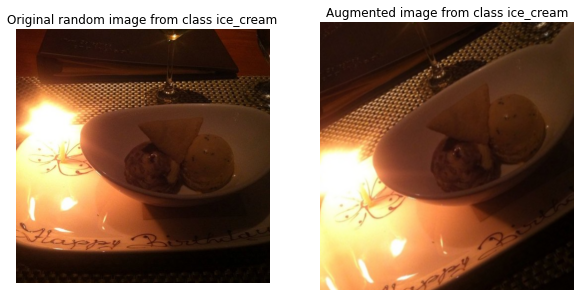

In [57]:
img = mpimg.imread(random_image_path)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img);
plt.axis(False);
plt.title(f"Original random image from class {target_class}");

augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training = True)
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False);
plt.title(f"Augmented image from class {target_class}");